In [1]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
import math
import seaborn as sns

In [2]:
## pareto analysis
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
primary=[]
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric,primary=primary):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    solution_primary=[]
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            primary_dark=[]
            for i in model.reactions:
                primary_dark.append(i.id)
            solution_primary.append(solution.fluxes[primary_dark])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            #result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    #return result_list
    return solution_primary

In [3]:
## Plots
#model = cobra.io.load_matlab_model(join('/home/subasree/Desktop/Models_to_work/alpha_day_DM.mat'))
model_rs = read_sbml_model('/Users/subasrees/Desktop/Core_Model_Simulations/beta_antiox_dm.xml')#beta_antiox_dm beta_day_RS_DM
core_model=model_rs

##Constraints
rubisco = core_model.problem.Constraint(3 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
core_model.add_cons_vars([rubisco])

atp = core_model.problem.Constraint((0.0049*core_model.reactions.get_by_id("Photon_tx").flux_expression+2.7851)-core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp)

atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-16


In [5]:
k=[]
for i in core_model.reactions:
    r=core_model.get_associated_groups(i)
    k.append(r)

In [6]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell' #DM_ho2_rad_cell AraCore_Biomass_tx DM_HS_cell DM_CPD0-1395_cell'DM_SUPER_OXIDE_cell'#'DM_NITRIC-OXIDE_cell'#'DM_CPD-12377_cell'#'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'#Arabidopsis_biomass_tx'#AraCore_Biomass_tx'
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')
data=pd.DataFrame(solution_primary)
data_t=data.T
#print(data_t.head())
index_len=np.arange(0,len(data_t.index),1)
indices=data_t.index
##
data_new=pd.DataFrame([data_t.iloc[:,0],data_t.iloc[:,39],data_t.iloc[:,77]])
df_new=data_new.T
## rename the three levels 
df_new.columns=['zero','half_max','full_max']
df_new['maximum']=abs(df_new).max(1)
df_new['formulas']=core_model.reactions
df_new['groups']=k
df=df_new[(df_new['maximum']!=0)]
col=['zero','half_max','full_max']
data_new = pd.DataFrame()
data_new.index=df.index
#data_new.columns=col
data_new['zero']=df['zero']/df['maximum']
data_new['half_max']=df['half_max']/df['maximum']
data_new['full_max']=df['full_max']/df['maximum']
data_new['formulas']=df['formulas']
data_new['groups']=df['groups']
data_new=data_new.sort_values(by=['full_max','half_max'],ascending=False)
print(len(data_new))




Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 96.54247182066658

Solving all iterations for Pareto frontier (FBA)...
404


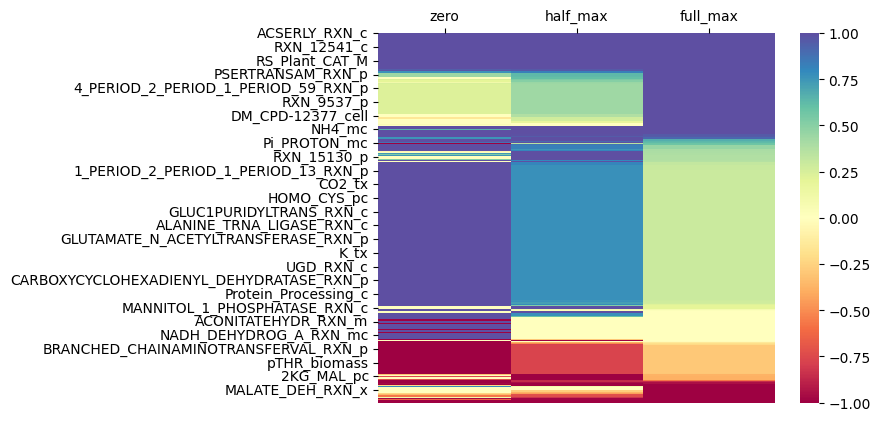

In [7]:
fig=figsize=(25, 20)
ax = sns.heatmap(data_new.iloc[:,0:3],yticklabels=15,cmap="Spectral")#DM_HS_cell=17 02S=16
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
# Spectral magma cubehelix icefire viridis  seismic coolwarm

In [8]:
#data_new.to_excel('/Users/subasrees/Desktop/heatmap_h2o2_77.xlsx')